# Analyzing the apartment rental prices in Prague

> This is a rendered version of a Jupyter notebook. The source notebook can be found [in my GitHub repository](https://github.com/barjin/ndbi023-project), along with the data used in this analysis.

In this data analysis, I tried to understand the apartment rental prices in Prague. The data was collected from the real estate website [Sreality.cz](https://www.sreality.cz/). The data from this source includes the monthly prices, the property sizes, geolocations, and other features. The goal of this analysis is to understand the factors that influence the rental prices of apartments in Prague.

## Acquiring the data

This section describes how the data was collected and preprocessed.

### SReality.cz

[Sreality.cz](https://www.sreality.cz/) is a real estate website that lists properties for sale and rent in the Czech Republic. The website provides a search interface where users can filter the properties based on various criteria. The frontend application sends requests to the API at the backend, which returns the search results in JSON format. The API is not documented, but it is possible to reverse-engineer the requests sent by the frontend application to the API.

The API also doesn't seem to employ any kind of rate limiting or bot detection. This makes it possible to scrape the data from the website with a very simple `curl` call (thanks!). The following command was used to collect the data:

```bash
#!/bin/bash

for i in $(seq 1 60); do # 60 pages approximately correspond to all the listings at the site at the time of writing
    echo "Downloading page $i";
    curl "https://www.sreality.cz/api/cs/v2/estates?category_main_cb=1&category_type_cb=2&locality_region_id=10&per_page=60&page=$i&tms=1715159262664" >> "data.json";
done
```



## First look into the data

Once we've acquired the data, we can load them into a pandas DataFrame and start the analysis.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data.csv')
df

,Unnamed: 0,locality,category_main_cb,furnished,object_type,parking_lots,price_summary_unit_cb,locality_street_id,terrace,balcony,...,low_energy,easy_access,building_condition,locality_country_id,garage,room_count_cb,energy_efficiency_rating_cb,price_summary_czk,garden_area,estate_area
0,0,"Maiselova, Praha 1 - Josefov",1.0,2.0,0.0,0.0,2.0,120458.0,0.0,1.0,...,0.0,0.0,1.0,112.0,0.0,0.0,7.0,35000.0,NaN,NaN
1,1,"Opatovická, Praha 1 - Nové Město",1.0,3.0,0.0,0.0,2.0,121234.0,1.0,1.0,...,0.0,0.0,9.0,112.0,0.0,0.0,3.0,49500.0,NaN,NaN
2,2,"Grafická, Praha 5 - Smíchov",1.0,1.0,0.0,1.0,2.0,119641.0,1.0,0.0,...,1.0,1.0,6.0,112.0,1.0,0.0,1.0,32500.0,NaN,NaN
3,3,"Holečkova, Praha 5 - Košíře",1.0,1.0,0.0,0.0,2.0,119726.0,0.0,0.0,...,0.0,0.0,1.0,112.0,0.0,1.0,7.0,33000.0,NaN,NaN
4,4,"Na zátorách, Praha 7 - Holešovice",1.0,1.0,0.0,0.0,2.0,120960.0,0.0,1.0,...,0.0,1.0,1.0,112.0,0.0,0.0,0.0,10158.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3655,3655,"Řeporyjská, Praha 5 - Jinonice",1.0,2.0,0.0,1.0,2.0,121745.0,0.0,0.0,...,0.0,0.0,6.0,112.0,1.0,0.0,3.0,23000.0,NaN,NaN
3656,3656,"Na Poříčí, Praha 1 - Nové Město",1.0,3.0,0.0,1.0,2.0,120809.0,1.0,0.0,...,0.0,0.0,1.0,112.0,1.0,0.0,7.0,75000.0,NaN,NaN
3657,3657,"náměstí Jiřího z Poděbrad, Praha 3 - Vinohrady",1.0,0.0,0.0,0.0,2.0,122964.0,0.0,0.0,...,0.0,0.0,2.0,112.0,0.0,0.0,0.0,40609.0,NaN,NaN
3658,3658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There seem to some `NaN` values in the data, which we need to handle. We can also drop the columns that are not relevant to our analysis.

In [3]:
df.isna().sum()

Unnamed: 0                        0
locality                          3
category_main_cb                  3
furnished                         3
object_type                       3
parking_lots                      3
price_summary_unit_cb             3
locality_street_id                3
terrace                           3
balcony                           3
locality_district_id              3
locality_ward_id                  3
loggia                            3
category_sub_cb                   3
building_type                     3
elevator                          3
locality_gps_lat                  3
basin                             3
locality_region_id                3
category_type_cb                  3
hash_id                           3
cellar                            3
object_kind                       3
locality_gps_lon                  3
usable_area                       3
locality_quarter_id               3
ownership                         3
locality_municipality_id    

In [4]:
df.drop(['garden_area', 'estate_area', 'Unnamed: 0'], inplace=True, axis=1)

df.dropna(inplace=True)

We can continue with a "sanity check" - let's plot it as a scatter plot onto a "map" of Prague.

In [6]:
plt.ioff()

df.plot(
    kind='scatter', 
    x='locality_gps_lon', 
    y='locality_gps_lat', 
    c="price_summary_czk" , 
    colormap='viridis', 
    s=3, 
    figsize=(15, 10), 
    title="Rental prices per month in Prague, Czech Republic",
    xlabel="Longitude",
    ylabel="Latitude",
).get_figure().savefig('img/01_rental_prices.png', bbox_inches='tight')

| ![Rental prices per month in Prague, Czech Republic](img/01_rental_prices.png) |
|:--:|
| *Plotting the rental prices per month with scatterplot on a "map" of Prague* |

> Note that using the geographical coordinates as cartesian coordinates does not map the distances correctly (because the Earth is not flat). However, for small distances (just like in our case here), the error is negligible.
>
> The figure might also be slightly distorted because of the `figsize` used - the aspect ratio is just approximated and might not represent the reality correctly.

Looking at the color scale in the chart above, it seems that some places cost more than 200k CZK a month. 

This is at least suspicious - let's explore that. By sorting the dataset by the price in descending order, we can find the ids of the listings and compose their URLs to the real estate websites to see what's going on.

In [5]:
df.sort_values(
    'price_summary_czk', 
    ascending=False
).head()['hash_id'].astype(int).map(
    lambda x: f'https://www.sreality.cz/detail/pronajem/byt/4+kk/abc/{x}'
).values

array(['https://www.sreality.cz/detail/pronajem/byt/4+kk/abc/2296964428',
       'https://www.sreality.cz/detail/pronajem/byt/4+kk/abc/2434610508',
       'https://www.sreality.cz/detail/pronajem/byt/4+kk/abc/1757791564',
       'https://www.sreality.cz/detail/pronajem/byt/4+kk/abc/3889546572',
       'https://www.sreality.cz/detail/pronajem/byt/4+kk/abc/238974284'],
      dtype=object)

| ![]( 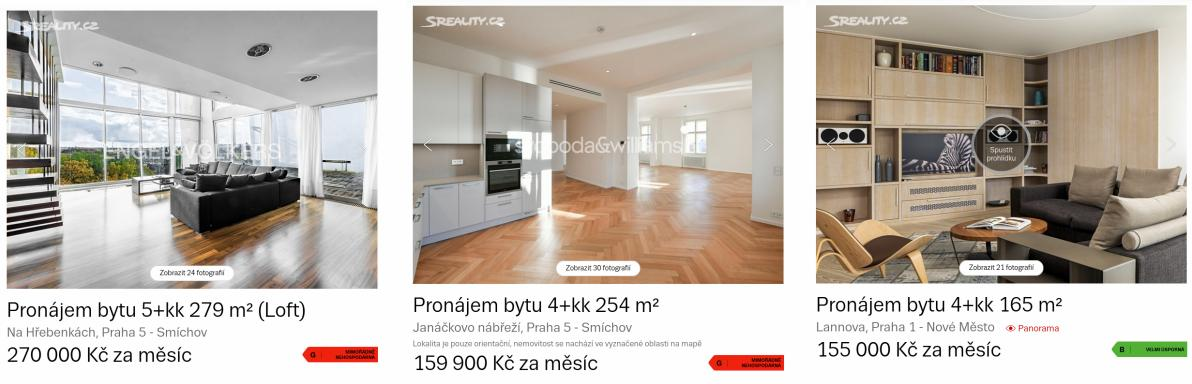) |
|:--:| 
| *Screenshots of the listings from the selection above* |

I stand corrected - these datapoints do not seem to be errorneous, there are just people with much more money than I would expect.

By using the `staticmap` library, we can generate an actual map of the listings. Let's try to plot the listings on a map of Prague.

To get more variance in the data, we can only plot the listings with a price of 50000 CZK per month or less.

In [6]:
import matplotlib.pyplot
import matplotlib.cm as cm
import matplotlib.colors as colors
from staticmap import StaticMap, CircleMarker
import matplotlib
import numpy as np
from PIL import Image

plt.ion()

def get_map(df, color_attribute='', title='', scale_label=''):
    m = StaticMap(1600, 1066)

    color_norm = colors.Normalize(
        vmin=df[color_attribute].min(), 
        vmax=df[color_attribute].max()
    )
    
    color_mapper = cm.ScalarMappable(
        norm=color_norm, 
        cmap='inferno'
    )

    for index, row in df.iterrows():
        point = CircleMarker(
            (row['locality_gps_lon'], 
             row['locality_gps_lat']), 
            color=tuple(np.floor(np.array(color_mapper.to_rgba(row[color_attribute])[:3]) * 255).astype(int)), 
            width=10)
        m.add_marker(point)

    image = m.render(zoom=12)

    fig, ax = matplotlib.pyplot.subplots(figsize=(15, 10))
    fig.suptitle(title, verticalalignment='bottom', fontsize=16, y=0.9)

    plt.colorbar(color_mapper, ax=ax, label=scale_label, fraction=0.03, pad=0.04)
    ax.imshow(image)

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

    return fig

plt.ioff()


In [7]:
get_map(
    df[df['price_summary_czk'] <= 50000], 
    color_attribute='price_summary_czk', 
    scale_label='Price in CZK / mo', 
    title='Rental prices per month in Prague, Czech Republic'
).savefig(
    'img/02_rental_prices_map.png', 
    bbox_inches='tight'
)

| ![Map of filtered listing prices](./img/02_rental_prices_map.png) |
|:--:|
| *Map of filtered listings. Prices are color coded.* |

Unsurprisingly, the priciest listings are located in the areas of Prague 1 and Prague 2, which is the city center.

The total price of the listing might not be the best measure however, as we didn't account for the usable areas of the estate. We can try to plot the price per square meter instead.

In [8]:
df['price_per_sqm'] = df['price_summary_czk'] / df['usable_area']

In [9]:
get_map(
    df[df['price_per_sqm'] < 700], 
    color_attribute='price_per_sqm',
    title='Price per sqm in Prague, Czech Republic'
).savefig(
    'img/03_price_per_sqm_map.png', 
    bbox_inches='tight'
)

| ![Map of filtered listing prices per square meter](./img/03_price_per_sqm_map.png) |
|:--:|
| *Map of filtered listings per square meter. Prices are color coded.* |

It really seems that there are certain "high-rent" areas in Prague. We can try to train a set of SVM classifiers with appropriate kernels (e.g. RBF) and see if we can use the SVM boundaries to visualize the areas on the map.

In [98]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import sklearn.metrics as metrics

X_train, X_test, y_train, y_test = train_test_split(
    df[['locality_gps_lon', 'locality_gps_lat']], 
    df['price_per_sqm'] > df['price_per_sqm'].median()
)

pipeline = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('svc', SVC(kernel='rbf', gamma='auto', C=10))
])

pipeline.fit(X_train.to_numpy(), y_train.to_numpy())

pred = pipeline.predict(X_test.to_numpy())

print(metrics.f1_score(y_test, pred))


0.6850393700787402


We managed to train the classifier with F1 score of roughly `0.68`. This is not a great score - perhaps it's hinting at the fact that the price of the listing is not only dependent on the location (or that we might need to tweak the hyperparameters a bit better). 

For now, let's stick with the SVM boundaries and plot them on the map.

In [103]:
import PIL
import urllib
import sklearn.inspection as inspection
import matplotlib

feature_1, feature_2 = np.meshgrid(
    np.linspace(X_train['locality_gps_lon'].min(), X_train['locality_gps_lon'].max(), num=50),
    np.linspace(X_train['locality_gps_lat'].min(), X_train['locality_gps_lat'].max(), num=50)
)

grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T

plt.ioff()

y_pred = np.reshape(pipeline.predict(grid), feature_1.shape)

fig, ax = matplotlib.pyplot.subplots(figsize=(15, 15))

image = np.array(
    PIL.Image.open(
        urllib.request.urlopen(
            f'https://maps.geoapify.com/v1/staticmap?style=osm-carto&width=1000&height=600&area=rect:{df["locality_gps_lon"].min()},{df["locality_gps_lat"].min()},{df["locality_gps_lon"].max()},{df["locality_gps_lat"].max()}&apiKey=d548c5ed24604be6a9dd0d989631f783'
        )
    )
)

ax.imshow(
    image, 
    alpha=1,
    extent=[
        df['locality_gps_lon'].min(), 
        df['locality_gps_lon'].max(), 
        df['locality_gps_lat'].min(), 
        df['locality_gps_lat'].max()
    ],
)

inspection.DecisionBoundaryDisplay.from_estimator(
    pipeline, 
    X_train.to_numpy(), 
    ax=ax, 
    plot_method='contour', 
    grid_resolution=200
)

ax.set_xbound(df['locality_gps_lon'].min(), df['locality_gps_lon'].max())
ax.set_ybound(df['locality_gps_lat'].min(), df['locality_gps_lat'].max())

fig.savefig('img/04_decision_boundaries.png', bbox_inches='tight')

| ![SVM boundaries](./img/04_decision_boundaries.png) |
|:--:|
| *Decison boundaries for the trained SVM classifier over the map of Prague. Brighter color signifies higher probability of the listing being in the above-median area.* |

Quite unsurprisingly, this experiment circled out the city center as the most expensive area. On the other hand, the suburbs seem to be classified as below-median areas - the area of Praha-Běchovice and Černý Most stand out the most with the concentration of the boundary lines around them (eastern part of Prague, near the D0 and D11 junction).

Other, less defined below-median areas seem to be around Uhříněves (south-east), Braník (south) and Hostivice (west).